In [3]:
import cv2
import time
import os
import math
import sys
from matplotlib import pyplot as plt

sys.path.append("../modules/")

import input_output
import processor

det = processor.Processors ()

det.add_processor ("contour_extraction")
det.add_processor ("perspective_warping")

low_th  = (200, 200, 200)
high_th = (255, 255, 255)
det.add_filter (processor.inrange (low_th, high_th), "contour_extraction", "inrange rgb")
det.add_filter (processor.leave_max_area_cc (),      "contour_extraction", "max_cc_extraction")
det.add_filter (processor.contour_approximation (),  "contour_extraction", "contour_approximation")

det.add_filter (processor.warp_perspective (), "perspective_warping", "warp perspective")
det.add_filter (processor.gamma_correction (1), "perspective_warping", "gamma correction")
#det.add_filter (processor.colorspace_to_colorspace ("RGB", "HSV"),
#                "basket", "colorspaces change 1")

source  = input_output.Source ("../data/birdview.mov")
#source = input_output.Source ("../data/images/rgb_basket.jpg")
#source  = input_output.Source ("1")

out = input_output.Writer ("warped.mp4", 1400, 392)

while (True):
    _, frame = source.get_frame ()

    contour, success = det.process (frame, "contour_extraction")
    stages_contour = det.get_stages_picts ("contour_extraction")
    
    det.processors ["perspective_warping"] ["warp perspective"].set_parameters_as_contour (contour)
    warped, success = det.process (frame, "perspective_warping")
    stages_warp = det.get_stages_picts ("perspective_warping")
    
    output_frame = input_output.form_grid (stages_contour + stages_warp, window_x_sz=1400)
    cv2.imshow ("output", output_frame)
    
    #print (output_frame.shape)
    out.write (output_frame)
    
    time.sleep (0.02)
    keyb = cv2.waitKey (1) & 0xFF

    if (keyb == ord('q')):
        break

source.release()
cv2.waitKey (1)
cv2.destroyAllWindows()

video


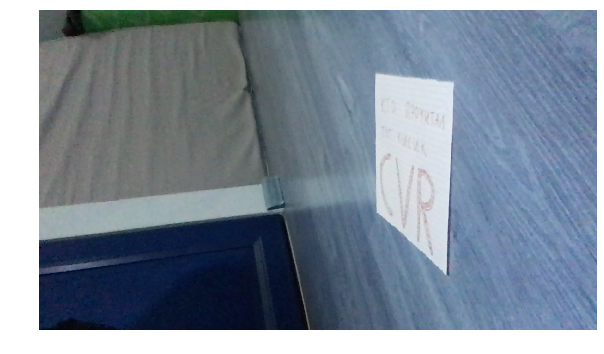

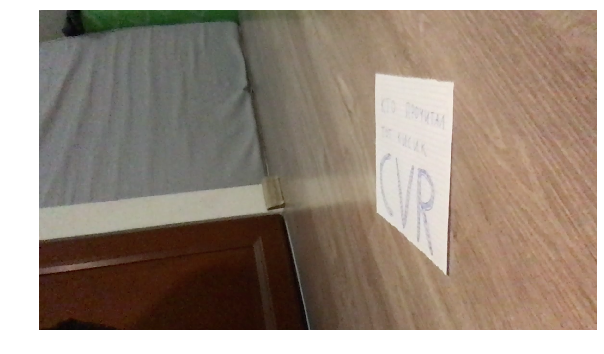

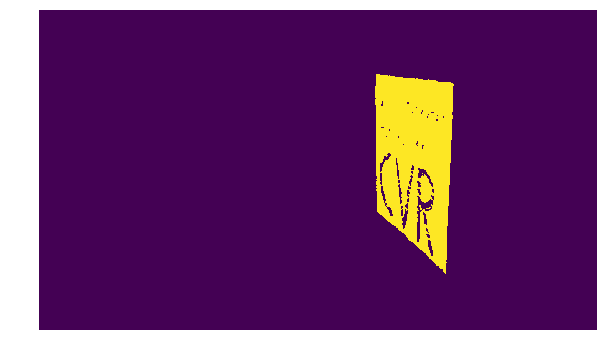

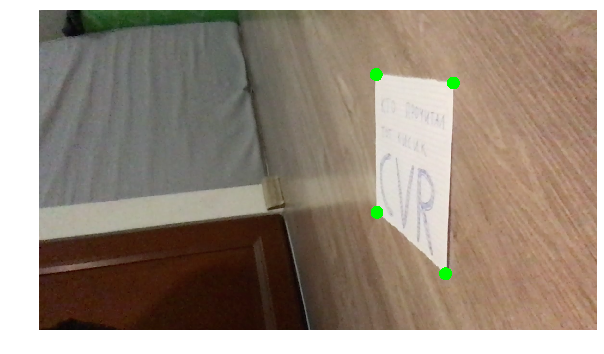

In [13]:
import numpy as np
import cv2
import time
import os
import math
import sys
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

img = cv2.imread ("../data/images/unwarped.png", cv2.IMREAD_COLOR)

plt.imshow (img)
plt.axis ('off')
plt.show ()

img_rgb = cv2.cvtColor (img, cv2.COLOR_BGR2RGB)

plt.imshow (img_rgb)
plt.axis ('off')
plt.show ()

low_th  = (200, 200, 200)
high_th = (255, 255, 255)

mask = cv2.inRange (img, low_th, high_th)

plt.imshow (mask)
plt.axis ('off')
plt.show ()

#contour extraction
contours, hierarchy = cv2.findContours (mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours [0]

approx = cv2.convexHull (cnt)

epsilon = 0.05 * cv2.arcLength (approx, True)
approx = cv2.approxPolyDP (approx, epsilon, True)

contour_marked = cv2.drawContours (img_rgb, approx, -1, (0, 255, 0), 53)

plt.imshow (contour_marked)
plt.axis ('off')
plt.show ()



app [[[1404  268]]

 [[1725  303]]

 [[1693 1096]]

 [[1407  840]]]
pts (4, 2)


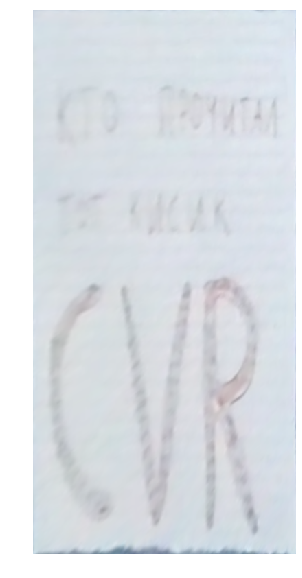

In [21]:
def order_points(pts):
    print ("pts", pts.shape)
    
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped

#p = self.parameters
#pts = np.array([(p["x1"], p["y1"]), (p["x2"], p["y2"]), (p["x3"], p["y3"]), (p["x4"], p["y4"])], dtype="float32")

# apply the four point tranform to obtain a "birds eye view" of
# the image

print ("app", approx)

warped = four_point_transform (img, np.asarray (approx) [:, 0, :])

#return warped

plt.imshow (warped)
plt.axis ('off')
plt.show ()
